<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/CNN%20dist%20alt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas-ta

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import pandas_ta as ta
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.initializers import GlorotUniform

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv("/content/drive/MyDrive/eurusd_hour.csv")
print(df)

             Date   Time       BO       BH       BL       BC      BCh  \
0      2005-05-02  00:00  1.28520  1.28520  1.28400  1.28440 -0.00080   
1      2005-05-02  01:00  1.28440  1.28480  1.28390  1.28420 -0.00020   
2      2005-05-02  02:00  1.28430  1.28540  1.28410  1.28510  0.00080   
3      2005-05-02  03:00  1.28510  1.28590  1.28500  1.28510  0.00000   
4      2005-05-02  04:00  1.28520  1.28590  1.28490  1.28550  0.00030   
...           ...    ...      ...      ...      ...      ...      ...   
93079  2020-04-29  18:00  1.08620  1.08851  1.08611  1.08713  0.00093   
93080  2020-04-29  19:00  1.08711  1.08823  1.08659  1.08748  0.00037   
93081  2020-04-29  20:00  1.08747  1.08788  1.08691  1.08708 -0.00039   
93082  2020-04-29  21:00  1.08708  1.08740  1.08699  1.08714  0.00006   
93083  2020-04-29  22:00  1.08728  1.08760  1.08727  1.08743  0.00015   

            AO       AH       AL       AC      ACh  
0      1.28540  1.28540  1.28420  1.28460 -0.00080  
1      1.28460  1

In [5]:
Date = pd.DataFrame()
new = pd.DataFrame()

new['Date'] = pd.to_datetime(df['Date'])
new['Time'] = pd.to_datetime(df['Time'])

Date['day'] = new['Date'].dt.day
Date['month'] = new['Date'].dt.month
Date['weekday'] = new['Date'].dt.weekday
Date['hour_of_day'] = new['Time'].dt.hour

scaler = MinMaxScaler(feature_range=(-1, 1))

# Scale each column individually
for column in Date.columns:
    Date[column] = scaler.fit_transform(Date[[column]])


print(Date.shape)

(93084, 4)


In [6]:
change = df['ACh']
change.name = 'change'
target = df['ACh'].shift(-3)
target.name = 'target'

combined_series = pd.concat([change, target,Date], axis=1)
combined_series = combined_series.dropna(axis=0)

target = combined_series.pop('target')
Change = combined_series

target = target.values

print(Change.shape)

(93081, 5)


In [7]:
def reshape_time_series(data, window_length, stride):
    num_windows = (len(data) - window_length) // stride + 1
    sliding_windows = np.lib.stride_tricks.sliding_window_view(data, window_shape=(window_length,))
    reshaped_data = sliding_windows[:num_windows * stride:stride]

    return reshaped_data

In [8]:
def reshape_time_series_2(data, window_length, stride):
    # Calculate the number of windows
    num_windows = (len(data) - window_length) // stride + 1

    # Create sliding windows
    sliding_windows = np.lib.stride_tricks.sliding_window_view(data, window_shape=(window_length, 5))

    # Reshape the data
    reshaped_data = sliding_windows[:num_windows * stride:stride]
    reshaped_data = reshaped_data.reshape((num_windows, window_length, 5))

    return reshaped_data

In [9]:

Change_win = reshape_time_series_2(Change,100,1)
np.set_printoptions(suppress=True)

# Get the desired shape from the second array
desired_shape = Change_win.shape[0]

# Slice the first array to match the desired shape
target_adju = target[:desired_shape]


print(target_adju.shape)
print(Change_win.shape)


(92982,)
(92982, 100, 5)


In [10]:
def my_dist(params):
    return tfp.distributions.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))

In [54]:
class NormalDistributionRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, strength=.00001):
        self.strength = strength

    def __call__(self, x):
        return self.strength * (
            tf.reduce_sum(tf.square(tf.abs(x) - 0.5))
        )

In [63]:
class NormalDistributionRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, strength=.00001):
        self.strength = strength

    def __call__(self, x):
        return self.strength * (
            tf.reduce_sum(tf.abs(x) - 0.5)
        )

In [64]:
input_length = 100
input_channels = 5
dropout_rate = .2

model = tf.keras.Sequential([
    layers.Conv1D(filters=64, kernel_size=3, strides=2, activation='LeakyReLU', input_shape=(input_length, input_channels), kernel_regularizer=NormalDistributionRegularizer(), kernel_initializer=GlorotUniform()),
    layers.Dropout(rate=dropout_rate),
    layers.Conv1D(filters=64, kernel_size=3, strides=2, activation='LeakyReLU', kernel_regularizer=NormalDistributionRegularizer(), kernel_initializer=GlorotUniform()),
    layers.Dropout(rate=dropout_rate),
    layers.Conv1D(filters=64, kernel_size=3, strides=2, activation='LeakyReLU', kernel_regularizer=NormalDistributionRegularizer(), kernel_initializer=GlorotUniform()),
    layers.Dropout(rate=dropout_rate),
    layers.Conv1D(filters=64, kernel_size=3, strides=2, activation='LeakyReLU', kernel_regularizer=NormalDistributionRegularizer(), kernel_initializer=GlorotUniform()),
    layers.Flatten(),
    layers.Dropout(rate=dropout_rate),
    layers.Dense(units=128, activation='LeakyReLU', kernel_regularizer=NormalDistributionRegularizer(), kernel_initializer=GlorotUniform()),
    layers.Dropout(rate=dropout_rate),
    layers.Dense(units=64, activation='LeakyReLU', kernel_regularizer=NormalDistributionRegularizer(), kernel_initializer=GlorotUniform()),
    layers.Dropout(rate=dropout_rate),
    layers.Dense(units=2, activation='linear', kernel_initializer=GlorotUniform()),  # 2 units for mean and variance
    tfp.layers.DistributionLambda(my_dist)
])
def NLL(y_true, distr):
    return -distr.log_prob(y_true)



In [65]:
def negative_log_likelihood(y_true, y_pred):
  return -tf.reduce_mean(y_pred.log_prob(y_true))
model.compile(optimizer='adam', loss=negative_log_likelihood)

In [ ]:
num_epochs = 10000
model.fit(x=Change_win, y=target_adju,batch_size=64, epochs=num_epochs)

Epoch 1/10000


In [ ]:
pred = model.predict(Change_win)

In [ ]:
plt.plot(pred)
plt.xlim(50200,50400)
plt.ylim(-.02,.02)
plt.plot(target)

In [58]:
weights = model.get_weights()

[ 0.28131062  0.2899721   0.28323722  0.26330176 -0.25066468  0.38699982
  0.39578173  0.41427746  0.16837595  0.27822205 -0.33828536  0.34778377
  0.3806222   0.222693    0.31707427  0.3597571   0.4278619  -0.30188882
 -0.37362683 -0.24223119  0.2564867  -0.29715425 -0.3543962   0.2048534
 -0.32782468  0.30744606  0.30209473  0.39683092  0.35560298  0.28870752
 -0.30838388 -0.26078492  0.3549577  -0.43558526 -0.28709581 -0.3071425
 -0.3217763  -0.3029503  -0.32421932 -0.25043204  0.29996273  0.30985436
 -0.2914108  -0.25289255 -0.21854706  0.33826968  0.3225912   0.34115377
 -0.23629992 -0.2842597   0.34015727 -0.29302132 -0.3580392  -0.34144363
  0.26574337  0.3226332   0.32036155  0.3075126  -0.31905663 -0.271482
 -0.2810996  -0.30844173  0.39455205 -0.3593225 ]


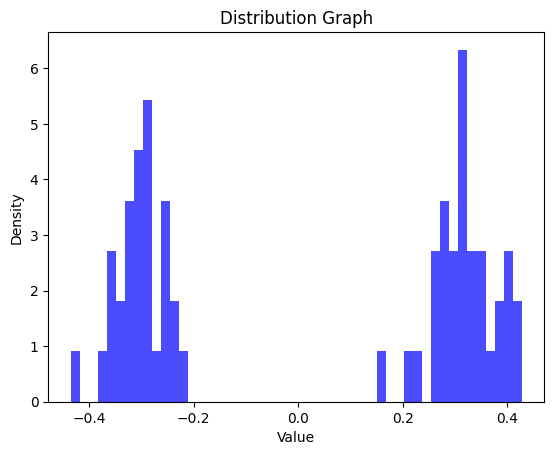

In [62]:
print(weights[0][2][0])
data = weights[0][2][0]
# Plot the distribution
plt.hist(data, bins=50, density=True, alpha=0.7, color='blue')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution Graph')

# Show the plot
plt.show()